# Model training

## Import libraries

The following command must be executed for balancing:

```conda install -c conda-forge imbalanced-learn```

In [ ]:
%pip install -q -U imbalanced-learn

In [18]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


In [15]:
from enum import Enum
import math


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_curve, fbeta_score, make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
from scipy import stats
from imblearn.over_sampling import RandomOverSampler


In [2]:
# Tensorflow may not be installed on every system

from keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Input
from scikeras.wrappers import KerasClassifier

## Methods

In [13]:
def truncate(number, digits) -> float:
    # Helper method that truncate scores to four decimals
    nbDecimals = len(str(number).split('.')[1])
    if nbDecimals <= digits:
        return number
    stepper = 10.0 ** digits
    return math.trunc(stepper * number) / stepper


def get_nested(data, *args):
    # Helper method that returns the value of a nested dictionary
    if args and data:
        element  = args[0]
        if element:
            value = data.get(element)
            return value if len(args) == 1 else get_nested(value, *args[1:])
    return None


def get_scores(y_test, y_predicted):
    # Method that returns different scores for the passed parameters
    digits = 4
    scores = {
        'Accuracy': truncate(accuracy_score(y_test, y_predicted), digits),
        'Recall': truncate(recall_score(y_test, y_predicted), digits),
        'Precision': truncate(precision_score(y_test, y_predicted), digits),
        'F1 score': truncate(f1_score(y_test, y_predicted), digits),
        'F2 score': truncate(fbeta_score(y_test, y_predicted, beta=2), digits)
    }
    return scores


def print_scores(all_scores):
    # Method that prints a table of the passed scores
    header_row = "{header:<20}".format(header="Estimator")
    for score in list(all_scores.values())[0]:
        header_row+="{header:>15}".format(header=score)
    print(header_row,"\n")

    for estimator in all_scores.keys():
        current_row = "{estimator:<20}".format(estimator=estimator)
        estimator_scores = all_scores.get(estimator)
        for score in estimator_scores:
            score_value = get_nested(all_scores, estimator, score)
            current_row+="{score_value:>15}".format(score_value=score_value)
        print(current_row)
        

def print_best_params(estimator_params):
    # Method that prints the best parameters
    for estimator in estimator_params.keys():
        print("Best parameters for "+estimator+": ")
        parameters = estimator_params.get(estimator)
        for parameter in parameters:
            print(parameter+": "+str(get_nested(estimator_params, estimator, parameter)))
            

def plot_roc(title, ax, y_test, y_predicted):
    # Method that plots the ROC for the passed parameters
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_predicted)
    ax.plot(false_positive_rate, true_positive_rate)
    ax.plot([0, 1], ls="--")
    ax.plot([0, 0], [1, 0] , c=".7"), plt.plot([1, 1] , c=".7")

    ax.set_title('Receiver Operating Characteristic (ROC) - '+title)
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')
    

def plot_feature_importance(title, ax, estimator, X_train):
    # Method that plots the feature importance for the passed parameters
    feat_importance = pd.Series(estimator.feature_importances_, index=X_train.columns)
    feat_importance.nlargest(12).plot(kind='barh', ax=ax)

    ax.set_title('Feature Importance for '+title)


def plot_learning_curve(title, estimator, ax, X, y, cv, scoring):
    # Method that plots the learning curve for the passed parameters
    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=4,
        train_sizes=np.linspace(0.1, 1.0, 5),
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    ax.grid()
    ax.fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    ax.fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    ax.plot(train_sizes, train_scores_mean, "o-", color="r", label="Training score")
    ax.plot(train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score")

    ax.set_title("Learning Curve: "+title)
    ax.set_xlabel("Training examples")
    ax.set_ylabel("Score")
    ax.legend()
    
    
def plot_loss(title, fitted_estimator):
    # plot loss during training
    plt.subplot(211)
    plt.title('{} \nLoss'.format(title))
    plt.plot(fitted_estimator.history['loss'], label='train')
    plt.plot(fitted_estimator.history['val_loss'], label='test')
    plt.legend()
    # plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(fitted_estimator.history['accuracy'], label='train')
    plt.plot(fitted_estimator.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
        

def model_evaluate(estimator, parameters, X_train, X_test, y_train, y_test, cv_folds=10):
    # Method that trains the passed model with the passed parameters and plots the evaluation of it
    scoring = make_scorer(fbeta_score, beta=2)

    # create the grid search instance
    grid_search_estimator = GridSearchCV(estimator=estimator.value,
                                         param_grid=parameters,
                                         scoring= scoring,
                                         cv=cv_folds,
                                         return_train_score=True,
                                         verbose=3,
                                         n_jobs=1
                                         )
    # training and prediction
    fitted_estimator_grid = grid_search_estimator.fit(X_train, y_train)
    best_fitted_estimator = fitted_estimator_grid.best_estimator_
    y_predicted = grid_search_estimator.predict(X_test)
    
    # evaluation of the model
    # TODO BL: @FL @JG should we use cross validation?
    print_scores({estimator.name: get_scores(y_test, y_predicted)})
    print_best_params({estimator.name: grid_search_estimator.best_params_})

    figure = plt.figure(figsize=(15, 15))
    figure_index = 1
    number_of_rows = 2
    number_of_columns = 2
    
    # plot roc
    ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
    plot_roc(title=estimator.name, ax=ax, y_test=y_test, y_predicted=y_predicted)
    figure_index += 1
    
    if estimator == Estimator.dnn_estimator:
        # plot loss and accuracy  
        plot_loss(title=estimator.name, fitted_estimator=best_fitted_estimator)
    
    # plot feature importance in case of forest estimator
    if estimator==Estimator.forest_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_feature_importance(title=estimator.name, ax=ax, estimator=grid_search_estimator.best_estimator_, X_train=X_train)
        figure_index += 1

    # plot learning curve in case of nn estimator
    if estimator==Estimator.nn_estimator:
        ax = figure.add_subplot(number_of_rows, number_of_columns, figure_index)
        plot_learning_curve(title=estimator.name, estimator=estimator.value, ax=ax, X=X_train, y=y_train, cv=cv, scoring=scoring)
        figure_index += 1
        
    if estimator==Estimator.log_regr_estimator:
        # TODO implement table output
        val = 0 # TODO
        headers = ["Coefficient", "value"]
        print_template = ""
        for i in range(len(headers)):
            k = len(headers[i])
            print_template += "{" + str(i) + ":" + str(k+5) + "}|"
        print(print_template.format(*headers))
        print(print_template.format("intercept", best_fitted_estimator.intercept_[0]))
        i = 0
        for coef in best_fitted_estimator.coef_[0]:
            feature_name = best_fitted_estimator.feature_names_in_[i]
            print(print_template.format(feature_name, round(coef, 5)))
            i += 1
    plt.show()
    # TODO maybe return fitted grid search estimator? what sense is there in returning the model
    return grid_search_estimator

## Setup data

Load preprocessed dataset and create objects X and y to store the data and the target value. Then split data into training data and testing data.

In [22]:
# Load dataset
heart_dataset = pd.read_csv('./heart_dataset_preprocessed.csv')

# Split and reduce dataset (reduction only for test purposes)
X = heart_dataset.drop(columns='HeartDisease')
y = heart_dataset['HeartDisease']
X_train, _, y_train, _ = train_test_split(X, y, test_size = 0.5, random_state = 42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size = 0.9, random_state = 42, stratify=y_train)

# Balance training data
# X_train, y_train = RandomOverSampler().fit_resample(X_train, y_train)

data_dict = {"X_train": X_train, "X_test": X_test, "y_train": y_train, "y_test": y_test}
print(y_train.value_counts(), y_test.value_counts())

0    14620
1     1369
Name: HeartDisease, dtype: int64 0    131591
1     12317
Name: HeartDisease, dtype: int64


## Baseline

We define a baseline model as a reference to the actual model with DummyClassifier from Scikit-Learn. Because our data is very imbalanced, we are using the stratified strategy.

Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

Dummy Classifier             0.8431         0.0881         0.0873         0.0877          0.088


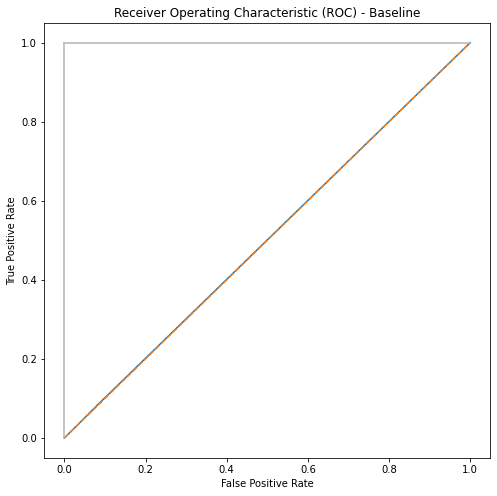

In [5]:
dummy_classifier = DummyClassifier(strategy='stratified')
dummy_classifier.fit(X_train, y_train)
y_predicted = dummy_classifier.predict(X_test)

print_scores({'Dummy Classifier':get_scores(y_test, y_predicted)})
plot_roc(title='Baseline', ax=plt.figure(figsize=(8, 8)).add_subplot(), y_test=y_test, y_predicted=y_predicted)
plt.show()

**Conclusion**

We achieve an 0.84 accuracy, a 0.09 recall, a 0.09 precision and a 0.09 F1-Score. Plotting the ROC curve shows that the baseline classifier is not really better than a random classifier


## Model selection

To find out which modeling method with which parameters best fits to our task, we define a set of modeling methods, train them with different parameters (hyperparameter tuning) and evaluate the results.

In [8]:
# Create DNN model
def create_model(dropout_rate, hidden_layer_sizes=(20, 20), activation='relu'):
    # create model
    model = Sequential()
    model.add(Input(shape=(X_train.columns.size,)))
    
    for hidden_layer_size in hidden_layer_sizes:
        model.add(Dense(hidden_layer_size, activation=activation))
    
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
              
    return model

# Enumeration class containing all estimators we want to consider for classification
class Estimator(Enum):
    knn_estimator=KNeighborsClassifier()
    nn_estimator=MLPClassifier(random_state=1)
    forest_estimator=RandomForestClassifier()
    svc_estimator=SVC(random_state=0)
    log_regr_estimator=LogisticRegression(random_state=42)
    dnn_estimator=KerasClassifier(model=create_model, verbose=0, hidden_layer_sizes=(30, 30), activation='sigmoid', dropout_rate=0.0)
    xgb_estimator=GradientBoostingClassifier(max_depth=1, random_state=0)

# Class Weights calculation
neg, pos = np.bincount(y_train)
total = neg + pos

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

# TODO JG: Adjust nn parameters
# Dictionary of parameter grids of the estimators
param_grids = {
    Estimator.knn_estimator: {
        'n_neighbors': [2, 3, 4, 5]
    },
    Estimator.forest_estimator: {
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0: weight_for_0, 1: weight_for_1}],
        'n_estimators': [20, 50, 100, 400, 800, 1000]
    },
    Estimator.svc_estimator: {
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'class_weight': [{0:1, 1:1}, {0:1, 1:2}, {0: weight_for_0, 1: weight_for_1}]
    },
    Estimator.nn_estimator: {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['lbfgs', 'sgd', 'adam'],
        'hidden_layer_sizes': [(60,30), (150,100,50), (120,80,40), (100,50,30)],
        'max_iter': [300, 500],
    },
    Estimator.dnn_estimator: {
        'batch_size': [64],
        'epochs': [400],
        'hidden_layer_sizes': [(512, 256, 128)],
        'activation': ['relu'],
        'loss': ['binary_crossentropy'],
        'optimizer': ['SGD'],
        'class_weight': [{0: weight_for_0, 1: weight_for_1}],
        'dropout_rate': [0.4]
    },
    Estimator.xgb_estimator: {
        'n_estimators': [200, 800, 1000],
        'loss': ['log_loss', 'deviance', 'exponential'],
        'criterion': ['friedman_mse', 'squared_error', 'mse'],
        'max_depth': [2, 5, 10],
        'activation': ['identity', 'logistic', 'tanh', 'relu']
    },
    Estimator.log_regr_estimator: {
        'solver': ['sag', 'saga' ], # TODO check also saga with elasticnet
        'max_iter': [200, 400, 1000], 
        'class_weight': [{0:1, 1:2}, {0:1, 1:1}, {0:1, 1:3}, {0:1, 1:4}, {0:1, 1:6}] # TODO revise maybe 
    }
}

In [ ]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# dnn estimator
estimator = Estimator.dnn_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
pd.DataFrame(grid.cv_results_)['rank_test_score']

In [ ]:
# XGBoost estimator
estimator = Estimator.xgb_estimator
grid = model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# knn estimator
estimator = Estimator.knn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# random forest estimator
estimator = Estimator.forest_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# nn estimator
estimator = Estimator.nn_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# svc estimator
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

In [ ]:
# svc estimator not oversampled
estimator = Estimator.svc_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict)

Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END max_iter=200, solver=sag;, score=(train=0.129, test=0.099) total time=   0.8s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END max_iter=200, solver=sag;, score=(train=0.115, test=0.129) total time=   0.6s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END max_iter=200, solver=sag;, score=(train=0.107, test=0.114) total time=   0.6s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 1/3] END max_iter=200, solver=saga;, score=(train=0.126, test=0.102) total time=   0.7s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/3] END max_iter=200, solver=saga;, score=(train=0.106, test=0.129) total time=   0.7s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/3] END max_iter=200, solver=saga;, score=(train=0.104, test=0.106) total time=   0.7s


C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Estimator                  Accuracy         Recall      Precision       F1 score       F2 score 

log_regr_estimator           0.9159         0.1015         0.5486         0.1714         0.1213
Best parameters for log_regr_estimator: 
max_iter: 200
solver: sag
Coefficient     |value     |
intercept       |-3.237594231932288|
BMI             |  -0.37418|
Smoking         |   0.25078|
AlcoholDrinking |  -0.23648|
Stroke          |   1.07863|
PhysicalHealth  |   0.09819|
MentalHealth    |   0.06705|
DiffWalking     |   0.21296|
Sex             |  -0.74501|
AgeCategory     |   0.04067|
Diabetic        |   0.59553|
PhysicalActivity|  -0.02548|
GenHealth       |  -2.02874|
SleepTime       |  -0.60778|
Asthma          |   0.15322|
KidneyDisease   |   0.43401|
SkinCancer      |   0.16935|
Race_American Indian/Alaskan Native|     -0.35|
Race_Asian      |   -0.5772|
Race_Black      |  -0.61546|
Race_Hispanic   |  -0.60971|
Race_Other      |  -0.46882|
Race_White      |  -0.36163|


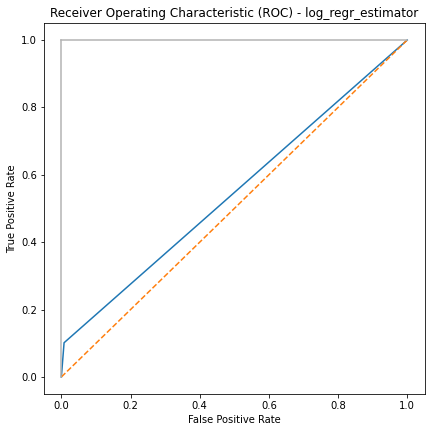

GridSearchCV(cv=3, estimator=LogisticRegression(random_state=42), n_jobs=1,
             param_grid={'max_iter': [200], 'solver': ['sag', 'saga']},
             return_train_score=True, scoring=make_scorer(fbeta_score, beta=2),
             verbose=3)

In [14]:
# logistic regression estimator
estimator = Estimator.log_regr_estimator
model_evaluate(estimator, param_grids.get(estimator), **data_dict, cv_folds=5)

In [24]:
iters = 1000
method = "bfgs"
log_regr_model_statsmodels = sm.Logit(y_train,  sm.add_constant(X_train, prepend=False))
log_regr_res_statsmodels = log_regr_model_statsmodels.fit(maxiter=iters, method=method)
print(log_regr_res_statsmodels.summary())

odds_ratios = pd.DataFrame(
    {
        "OR": log_regr_res_statsmodels.params,
        "Lower CI": log_regr_res_statsmodels.conf_int()[0],
        "Upper CI": log_regr_res_statsmodels.conf_int()[1],
    }
)
odds_ratios = np.exp(odds_ratios)
print(odds_ratios)

Optimization terminated successfully.
         Current function value: 0.230566
         Iterations: 143
         Function evaluations: 146
         Gradient evaluations: 146
                           Logit Regression Results                           
Dep. Variable:           HeartDisease   No. Observations:                15989
Model:                          Logit   Df Residuals:                    15967
Method:                           MLE   Df Model:                           21
Date:                Wed, 30 Nov 2022   Pseudo R-squ.:                  0.2112
Time:                        23:51:31   Log-Likelihood:                -3686.5
converged:                       True   LL-Null:                       -4673.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                          coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------

C:\Users\flola\AppData\Roaming\Python\Python310\site-packages\pandas\core\internals\blocks.py:402: RuntimeWarning: overflow encountered in exp
  result = func(self.values, **kwargs)


In [20]:
print(log_regr_res_statsmodels.summary2())

                                          Results: Logit
Model:                           Logit                       Pseudo R-squared:            0.211    
Dependent Variable:              HeartDisease                AIC:                         7417.0361
Date:                            2022-11-30 23:46            BIC:                         7585.9885
No. Observations:                15989                       Log-Likelihood:              -3686.5  
Df Model:                        21                          LL-Null:                     -4673.4  
Df Residuals:                    15967                       LLR p-value:                 0.0000   
Converged:                       1.0000                      Scale:                       1.0000   
---------------------------------------------------------------------------------------------------
                                     Coef.    Std.Err.      z     P>|z|      [0.025       0.975]   
-------------------------------------------

In [49]:
y_pred = log_regr_res_statsmodels.predict(sm.add_constant(X_test, prepend=False))

decision_boundary = 0.1

y_pred.loc[y_pred >= decision_boundary] = 1
y_pred.loc[y_pred < decision_boundary] = 0

from sklearn.metrics import confusion_matrix
tn, fp, fn, tp= confusion_matrix(y_test, y_pred).ravel()

print("tp | {} fn: {}\nfp | {} tn: {}".format(tp, fn, fp, tn))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

tp | 8907 fn: 3410
fp | 27253 tn: 104338
              precision    recall  f1-score   support

           0       0.97      0.79      0.87    131591
           1       0.25      0.72      0.37     12317

    accuracy                           0.79    143908
   macro avg       0.61      0.76      0.62    143908
weighted avg       0.91      0.79      0.83    143908



**Conclusion**

TODO: Add conclusion

## Final model

After having determined the best model and the best parameters for it in the step of model selection, we now apply this in the following.

In [ ]:
## TODO implement